In [1]:
# Test re-creation of BARRA2 ancilaries using u-ch954
from pathlib import Path
import typing as T
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy
import xarray as xr
import iris
import iris.plot
import numpy as np
import os
import textwrap
import itertools
import ants
import warnings

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/ants/regrid/esmf.py:26: UserWarning:  No module named 'ESMF'
Proceeding without capabilities provided by ESMPy (ESMF).
  warnings.warn(msg.format(str(_ESMF_IMPORT_ERROR)))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/ants/regrid/_ugrid.py:19: UserWarning:  No module named 'ESMF'
Proceeding without capabilities provided by ESMPy (ESMF).
  warnings.warn(msg.format(str(_ESMF_IMPORT_ERROR)))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/iris/experimental/raster.py:29: IrisDeprecation: iris.experimental.raster is deprecated since version 3.2, and will be removed in a future release. If you make use of this functionality, please contact the Iris Developers to discuss how to retain it (which may involve reversing the deprecation).
  warn_deprecated(wmsg)


In [2]:
ORIG_PATH = Path('/g/data/gb02/pag548/barra2-ancils/')
NEW_PATH = Path('/scratch/gb02/pag548/cylc-run/u-ch954/share/data/barra-r2/')

In [3]:
# check land-sea-mask
orig_lsm = xr.open_dataset( ORIG_PATH / 'land_sea_mask/cci/qrparm.mask.nc')
new_lsm = xr.open_dataset( NEW_PATH / 'land_sea_mask/cci/qrparm.mask.nc')

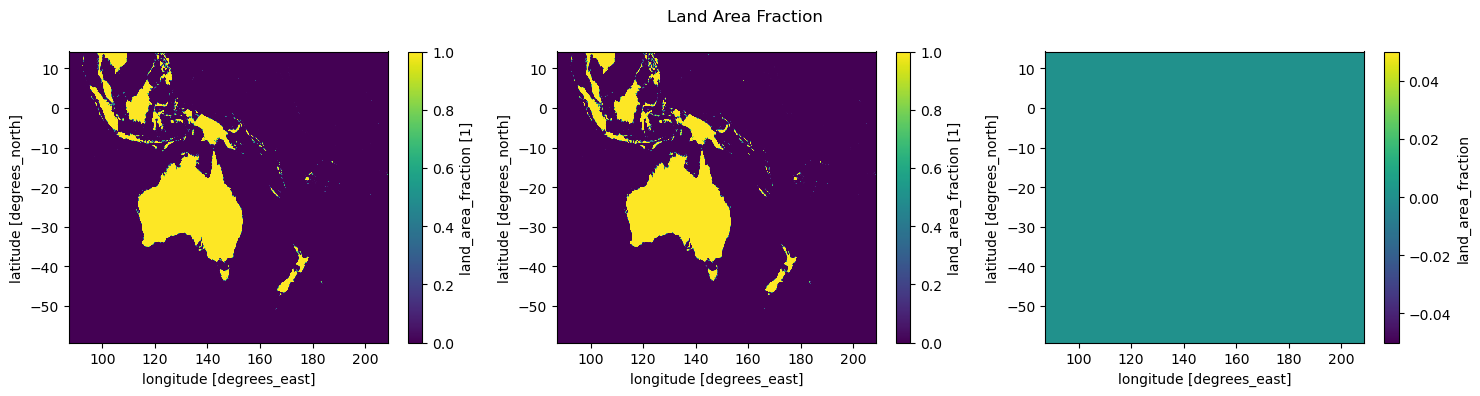

In [4]:
fig,ax=plt.subplots(1,3,figsize=(15,4))
orig_lsm.land_area_fraction.plot(ax=ax[0])
new_lsm.land_area_fraction.plot(ax=ax[1])
delta = new_lsm.land_area_fraction - orig_lsm.land_area_fraction
delta.plot(ax=ax[2])
fig.suptitle('Land Area Fraction')
plt.tight_layout()

In [5]:
delta.max().values

array(0.)

In [6]:
# So far so good. Lets look at some vegetation
orig_veg_frac = xr.open_dataset( ORIG_PATH / 'vegetation/fractions_cci-gl9/qrparm.veg.frac.nc')
new_veg_frac = xr.open_dataset( NEW_PATH / 'vegetation/fractions_cci-gl9/qrparm.veg.frac.nc')

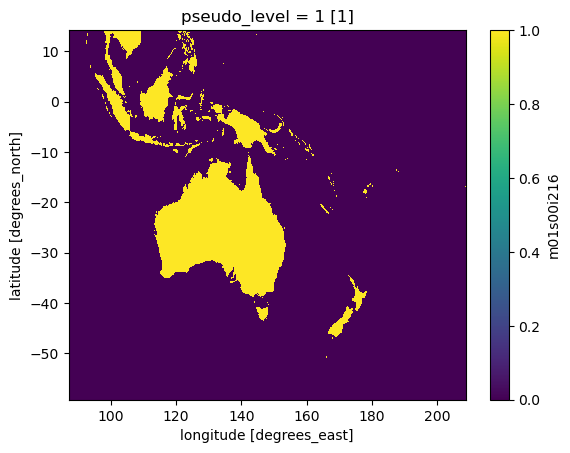

In [7]:
# We need to mask the original data.
orig_mask = xr.where(orig_veg_frac.m01s00i216[0] > 1e+10,0,1)
orig_mask.plot()

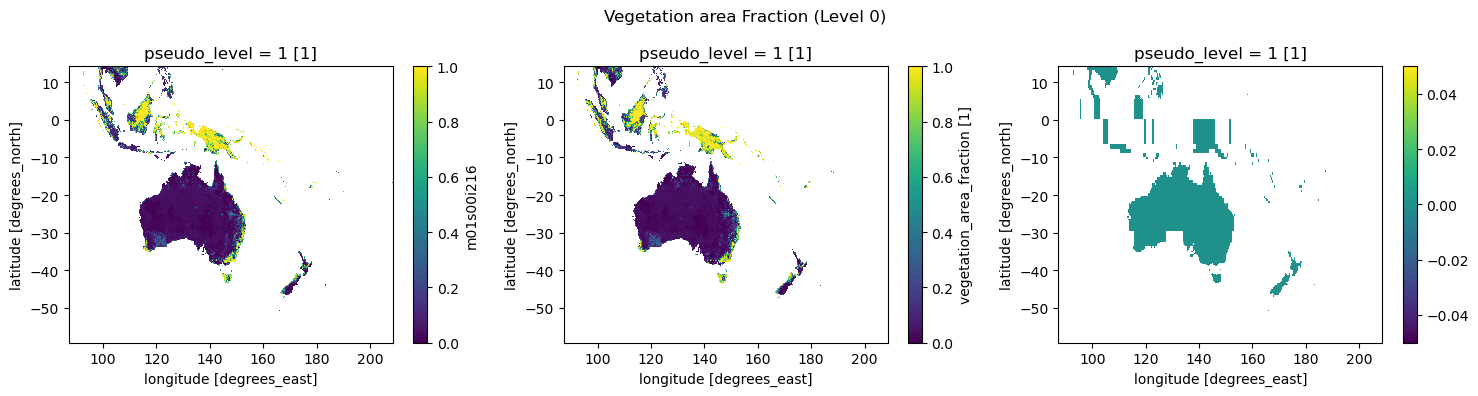

In [8]:
fig,ax=plt.subplots(1,3,figsize=(15,4))
orig_veg_frac.m01s00i216[0].where(orig_mask).plot(ax=ax[0])
new_veg_frac.vegetation_area_fraction[0].plot(ax=ax[1])
delta = new_veg_frac.vegetation_area_fraction[0] - orig_veg_frac.m01s00i216[0]
delta.plot(ax=ax[2])
fig.suptitle('Vegetation area Fraction (Level 0)')
plt.tight_layout()

In [9]:
delta.max().values

array(0.)

In [10]:
# The strange delta plot because the lat/lons of the grids are slightly different
delta_lats = orig_veg_frac.latitude.values - new_veg_frac.latitude.values
delta_lons = orig_veg_frac.longitude.values - new_veg_frac.longitude.values
print (f'Delta latitute maximum = {delta_lats.max()}')
print (f'Delta longitude maximum = {delta_lons.max()}')

Delta latitute maximum = 7.62939453125e-06
Delta longitude maximum = 1.52587890625e-05


In [11]:
# e.g.
orig_veg_frac.latitude.values[-10:]

array([13.200005, 13.310005, 13.420006, 13.530006, 13.640007, 13.750008,
       13.860001, 13.970001, 14.080002, 14.190002], dtype=float32)

In [12]:
new_veg_frac.latitude.values[-10:]

array([13.199997, 13.309998, 13.419998, 13.529999, 13.639999, 13.75    ,
       13.860001, 13.970001, 14.080002, 14.190002], dtype=float32)

In [13]:
orig_veg_frac.latitude.values[-10:] - new_veg_frac.latitude.values[-10:]

array([7.6293945e-06, 7.6293945e-06, 7.6293945e-06, 7.6293945e-06,
       7.6293945e-06, 7.6293945e-06, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00], dtype=float32)

In [14]:
# We can remove this anomaly by regridding
lats = orig_veg_frac.latitude.values
lons = orig_veg_frac.longitude.values
new_regrid = new_veg_frac.vegetation_area_fraction[0].interp(latitude=lats,longitude=lons)

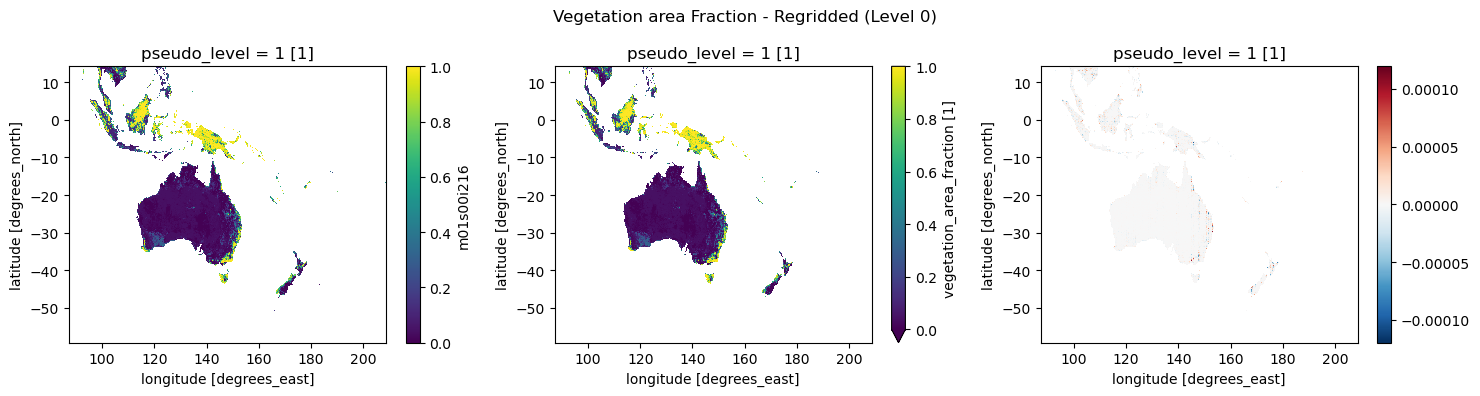

In [15]:
fig,ax=plt.subplots(1,3,figsize=(15,4))
orig_veg_frac.m01s00i216[0].where(orig_mask).plot(ax=ax[0])
new_regrid.plot(ax=ax[1],vmin=0)
delta = new_regrid - orig_veg_frac.m01s00i216[0]
delta.plot(ax=ax[2])
fig.suptitle('Vegetation area Fraction - Regridded (Level 0)')
plt.tight_layout()

In [16]:
# In which case we introduce small changes becaue of the regridding process. 
# Which is strange if the lat/lons of the old and new grids are identical?
print (f'Delta max = {delta.max().values}')
print (f'Delta min = {delta.min().values}')

Delta max = 0.00011958903245343211
Delta min = -0.0001112574394880328


In [17]:
# Anyway. Let's examine some of the problem regions, e.g. canopy height Macquarie Island
orig_veg_func = xr.open_dataset( ORIG_PATH / 'vegetation/func_type_simard/qrparm.veg.func.nc')
new_veg_func = xr.open_dataset( NEW_PATH / 'vegetation/func_type_simard/qrparm.veg.func.nc')

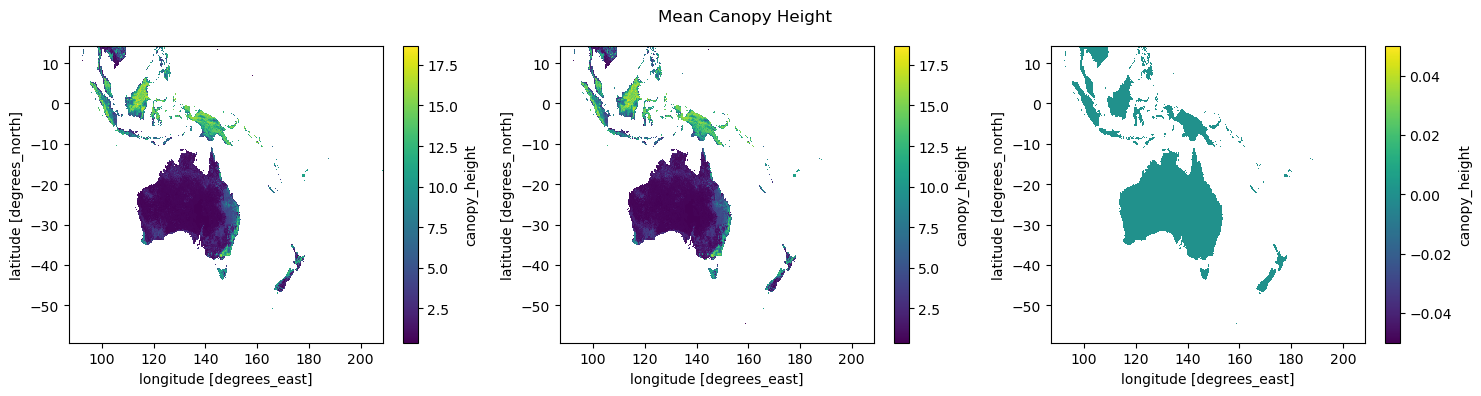

In [18]:
fig,ax=plt.subplots(1,3,figsize=(15,4))
orig_veg_func.canopy_height.mean(dim='time').mean(dim='dim1').plot(ax=ax[0])
new_veg_func.canopy_height.mean(dim='time').mean(dim='dim1').plot(ax=ax[1])
delta = new_veg_func.canopy_height.mean(dim='time').mean(dim='dim1') - \
        orig_veg_func.canopy_height.mean(dim='time').mean(dim='dim1')
delta.plot(ax=ax[2])
fig.suptitle('Mean Canopy Height')
plt.tight_layout()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/mule/stashmaster.py:284: UserWarning: Ancillary files do not define the UM version number in the Fixed Length Header. No STASHmaster file loaded: Fields will not have STASH entries attached.
  warnings.warn(msg)


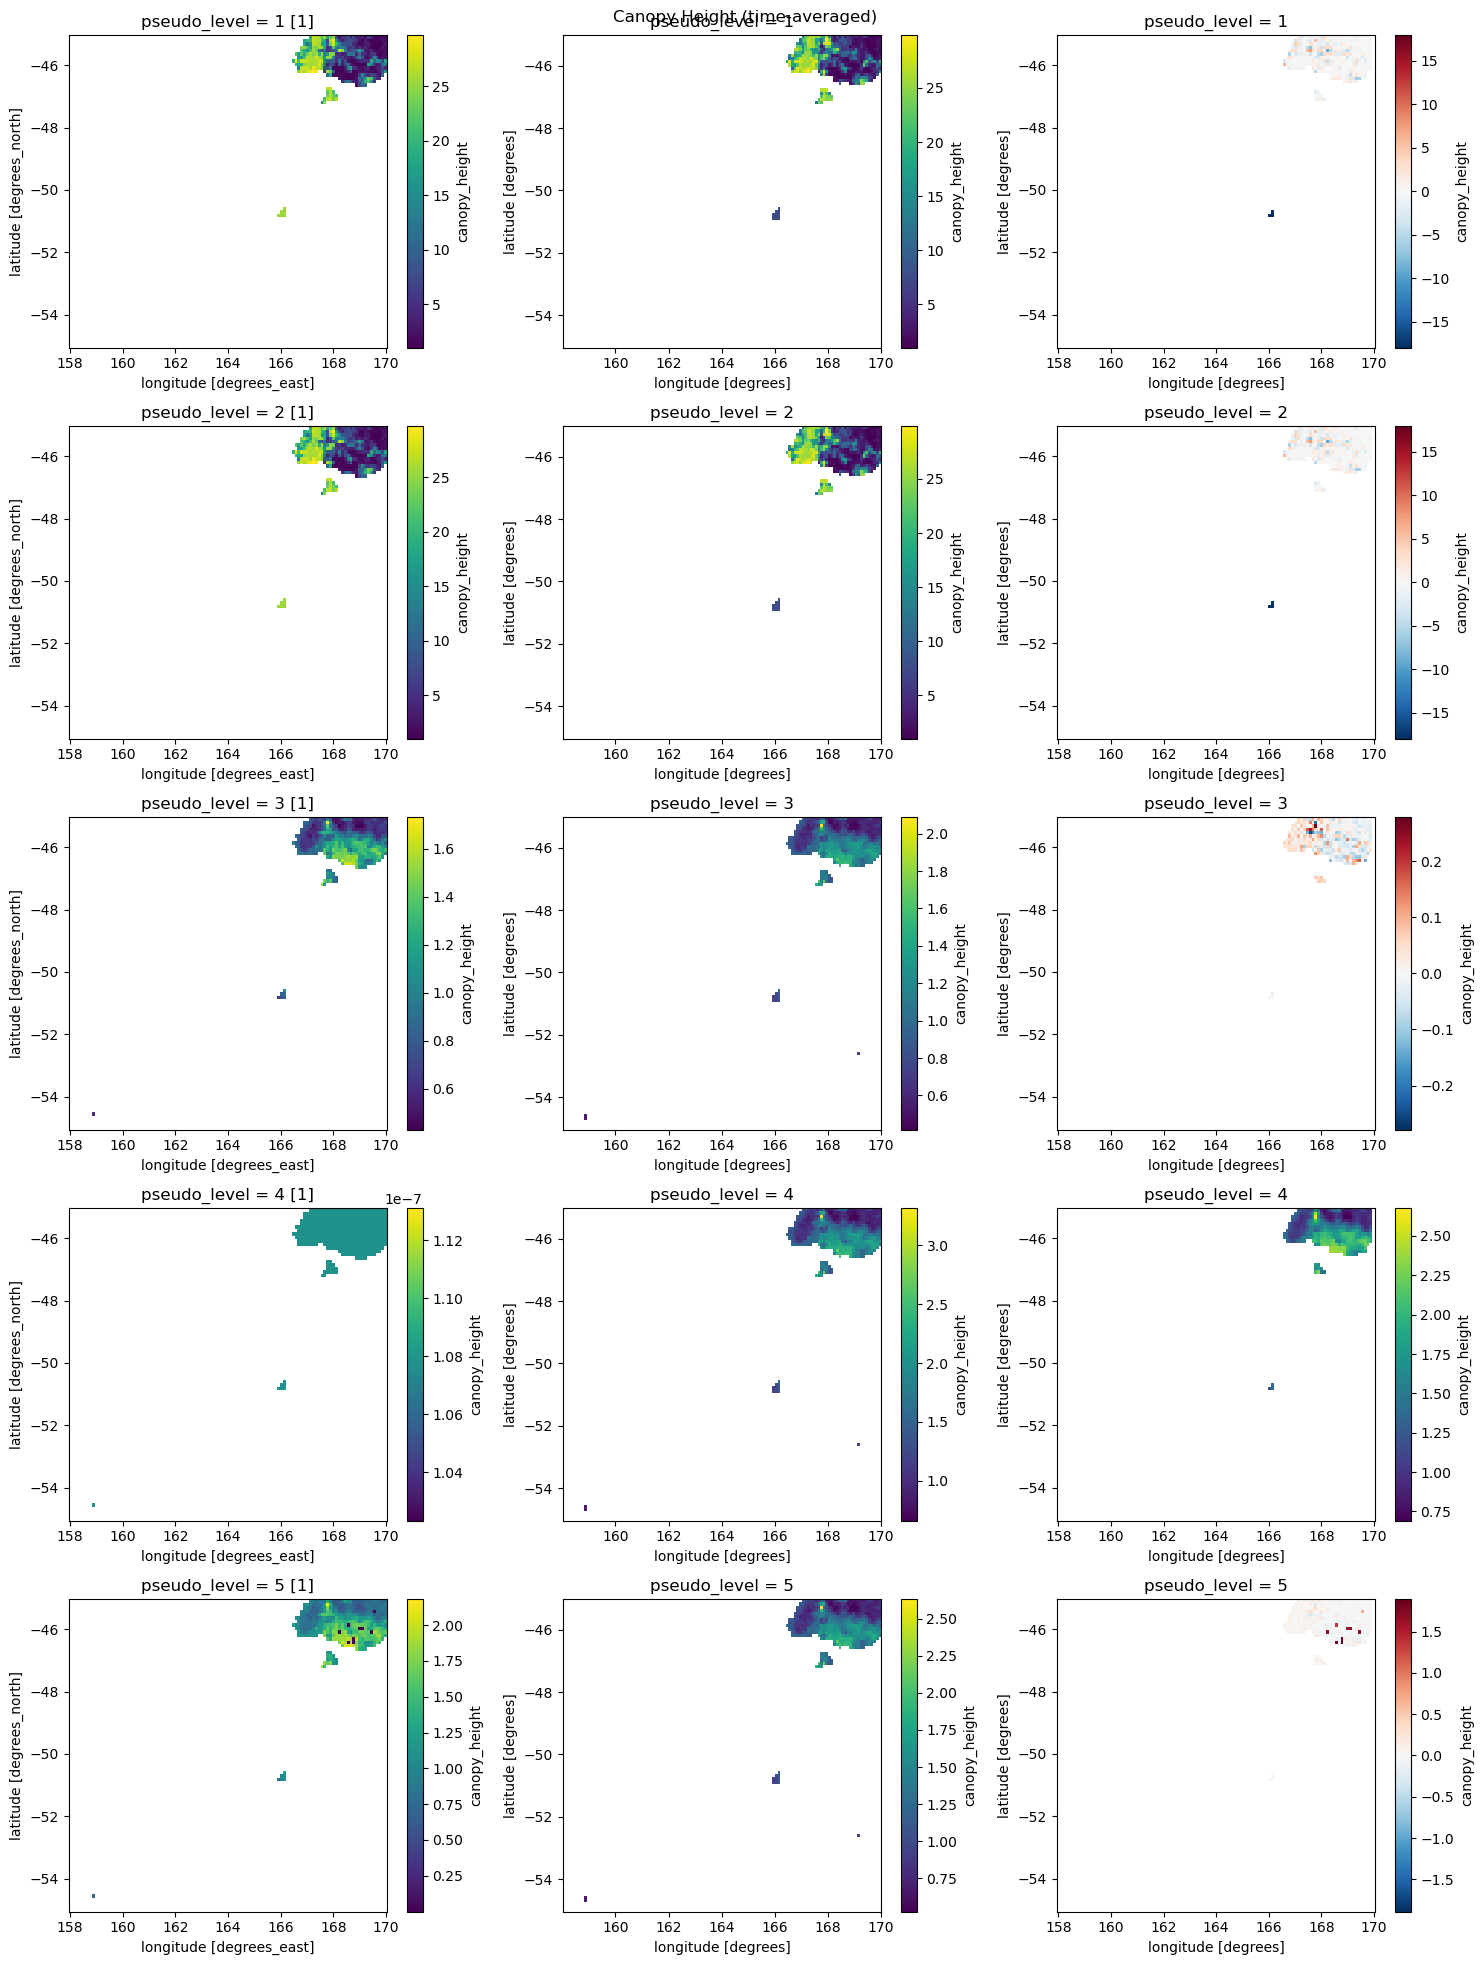

In [19]:
# Let's check around Macquarie island and compare with Regional Nesting
# Suite ancilaries (u-cy767}
RNS_PATH=Path('/home/548/pag548/cylc-run/u-dg767/share/data/ancils/Gippsland/era5')
rns_veg_cube = ants.load( RNS_PATH / 'qrparm.veg.func')[0]
rns_veg_func = xr.DataArray.from_iris(rns_veg_cube).compute()

# Plot all canopy heights around Macquarie Island and average over time.
fig,ax=plt.subplots(5,3,figsize=(15,20))
levels = orig_veg_func.dim1.values

for level in levels:

    orig = orig_veg_func.canopy_height.sel(latitude=slice(-55,-45),
                                    longitude=slice(158,170),
                                    dim1=level).\
                                    mean(dim='time')
    orig.plot(ax=ax[level,0])

    rns = rns_veg_func.sel(latitude=slice(-55,-45),
                           longitude=slice(158,170),
                           dim_0=level).\
                           mean(dim='time')
    rns.plot(ax=ax[level,1])

    lats = orig.latitude.values
    lons = orig.longitude.values
    
    delta = rns.interp(latitude=lats,longitude=lons)-orig
    delta.plot(ax=ax[level,2])

fig.suptitle('Canopy Height (time-averaged)')
plt.tight_layout()

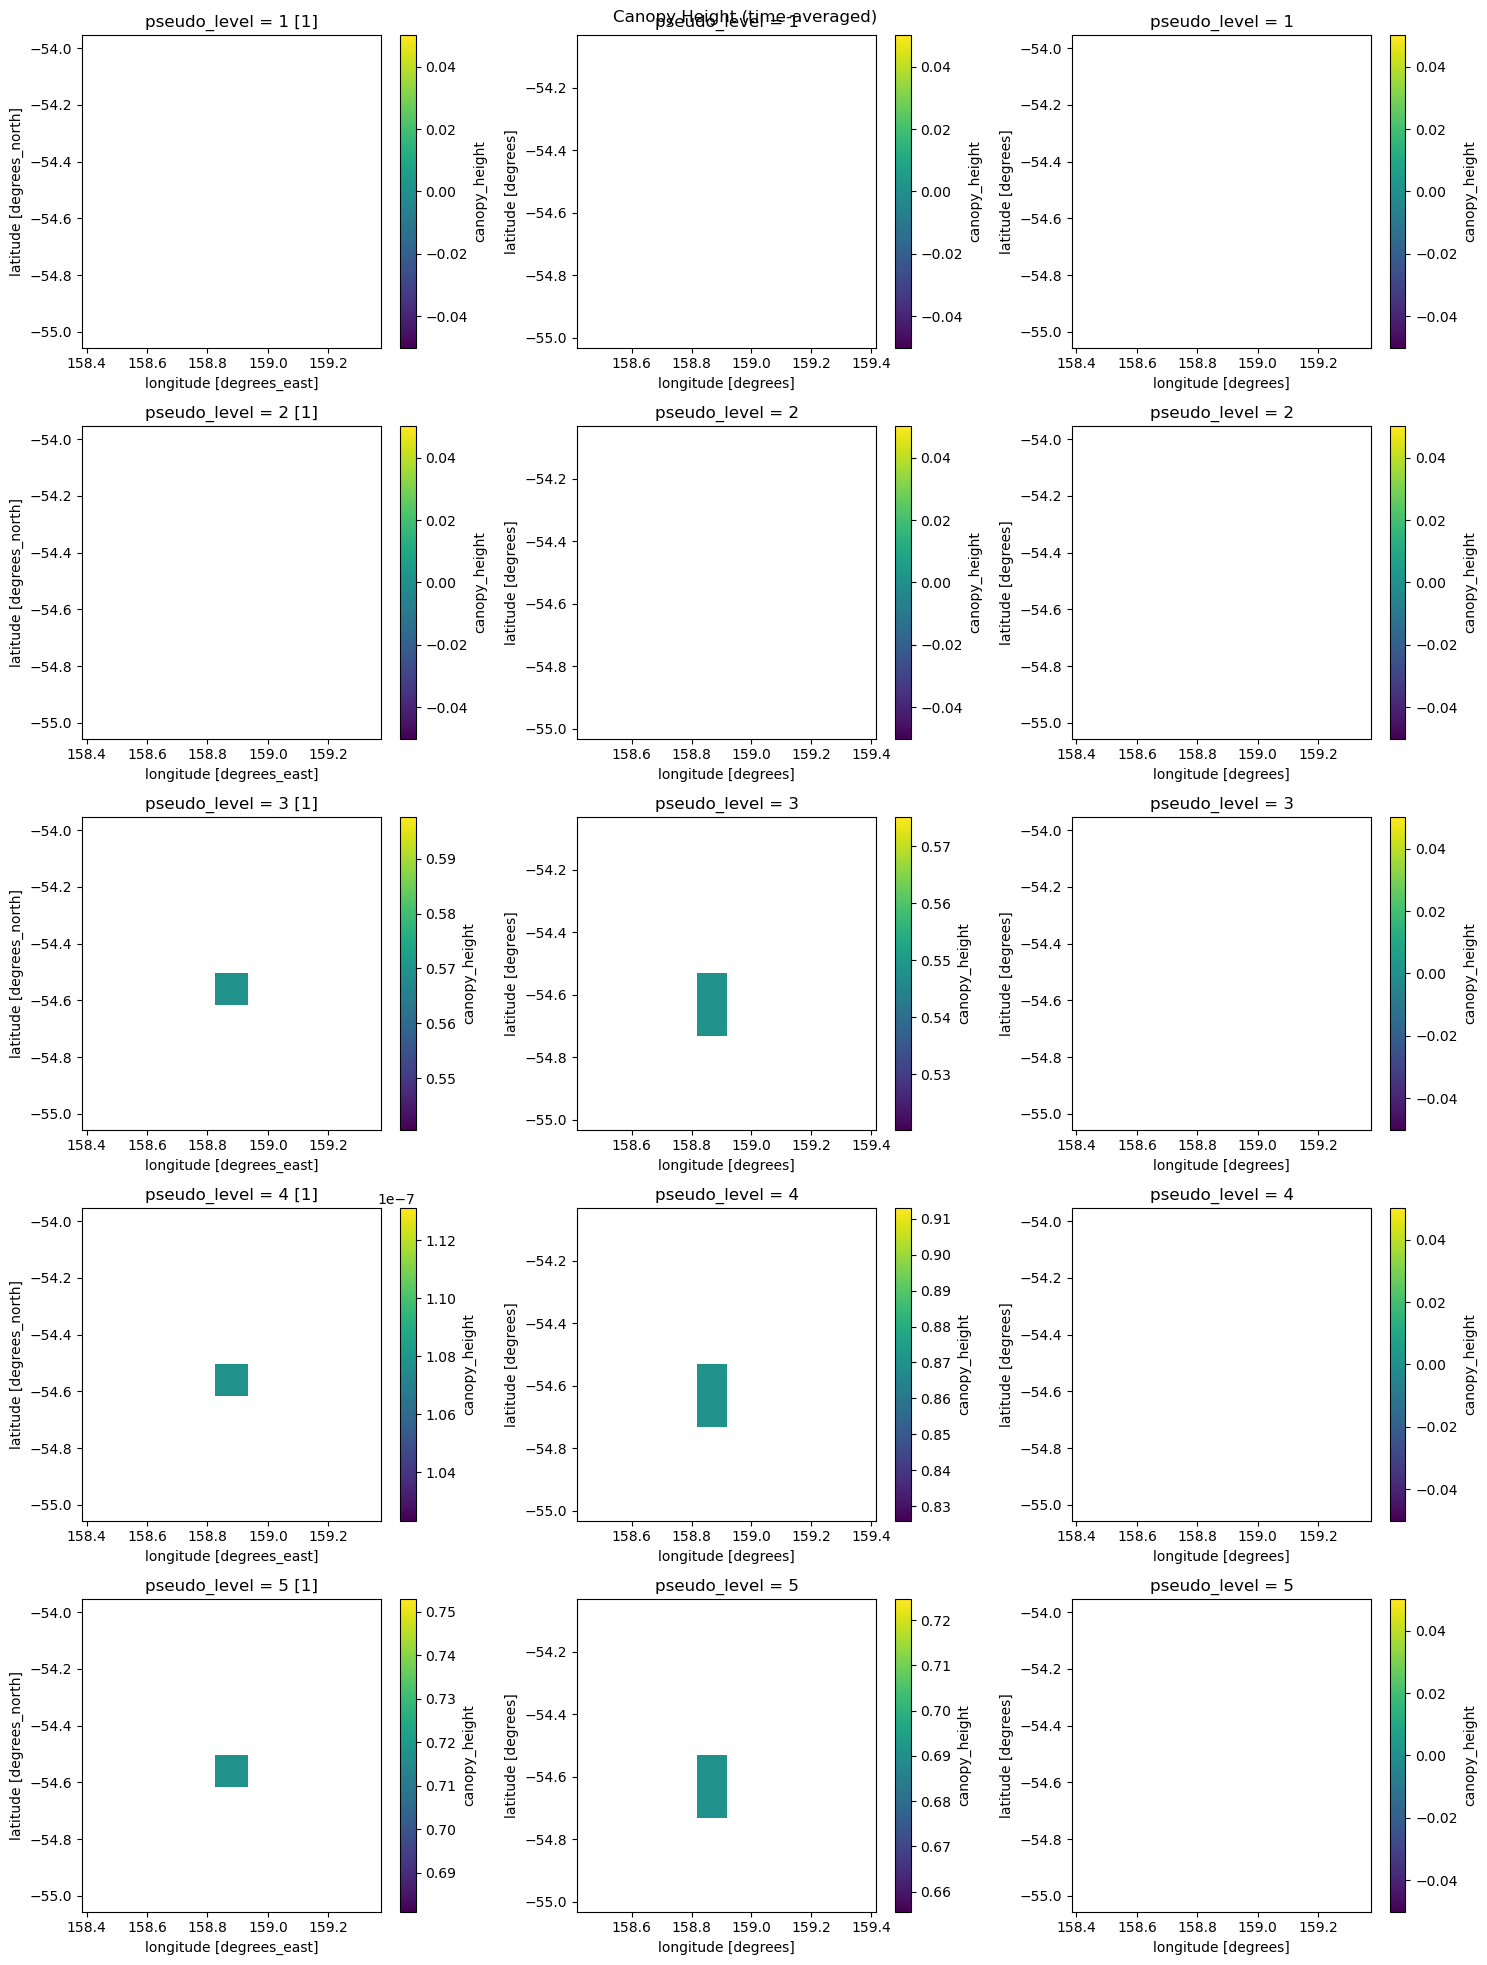

In [20]:
# This appears to have the same issue. Let's zoom in on Macquarie Island
fig,ax=plt.subplots(5,3,figsize=(15,20))
levels = orig_veg_func.dim1.values

for level in levels:

    orig = orig_veg_func.canopy_height.sel(latitude=slice(-55,-54),
                                    longitude=slice(158.4,159.4),
                                    dim1=level).\
                                    mean(dim='time')
    orig.plot(ax=ax[level,0])

    rns = rns_veg_func.sel(latitude=slice(-55,-54),
                           longitude=slice(158.4,159.4),
                           dim_0=level).\
                           mean(dim='time')
    rns.plot(ax=ax[level,1])

    lats = orig.latitude.values
    lons = orig.longitude.values
    
    delta = rns.interp(latitude=lats,longitude=lons)-orig
    delta.plot(ax=ax[level,2])

fig.suptitle('Canopy Height (time-averaged)')
plt.tight_layout()

func_type_merge


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/mule/stashmaster.py:284: UserWarning: Ancillary files do not define the UM version number in the Fixed Length Header. No STASHmaster file loaded: Fields will not have STASH entries attached.
  warnings.warn(msg)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/iris/fileformats/pp.py:1471: CFWarning: this date/calendar/year zero convention is not supported by CF
  self._t1 = cftime.datetime(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/iris/fileformats/pp.py:1504: CFWarning: this date/calendar/year zero convention is not supported by CF
  self._t2 = cftime.datetime(


('dim_0', 'month_number', 'latitude', 'longitude')
func_type_simard


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/mule/stashmaster.py:284: UserWarning: Ancillary files do not define the UM version number in the Fixed Length Header. No STASHmaster file loaded: Fields will not have STASH entries attached.
  warnings.warn(msg)


('dim_0', 'time', 'latitude', 'longitude')
func_type_modis


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/mule/stashmaster.py:284: UserWarning: Ancillary files do not define the UM version number in the Fixed Length Header. No STASHmaster file loaded: Fields will not have STASH entries attached.
  warnings.warn(msg)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/iris/fileformats/pp.py:1471: CFWarning: this date/calendar/year zero convention is not supported by CF
  self._t1 = cftime.datetime(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/iris/fileformats/pp.py:1504: CFWarning: this date/calendar/year zero convention is not supported by CF
  self._t2 = cftime.datetime(


('dim_0', 'month_number', 'latitude', 'longitude')


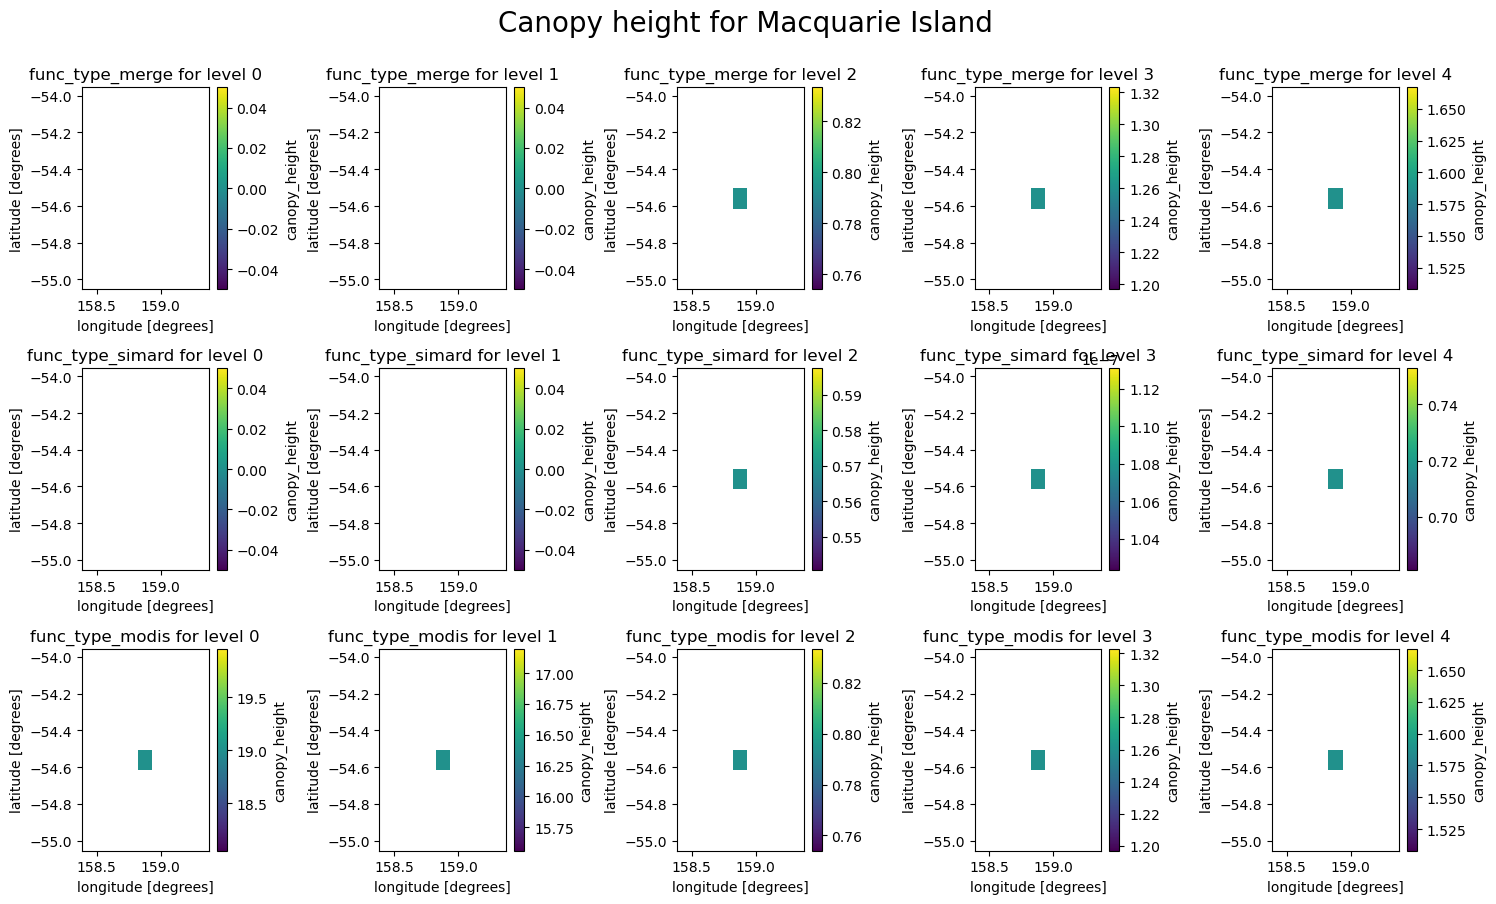

In [21]:
# Ok, let's loop through all the various BARRA vegetation files and
# see if any of them have values for all canopy heights over the island

func_files = (ORIG_PATH / 'vegetation' ).glob('*/qrparm.veg.func')

# Plot five fields for three files
num_plots=15
num_columns=5
num_rows = 3

fig_height = num_rows*3
fig_width = 15
max_label_length=30

Position = range(1,num_plots+1)

fig = plt.figure(figsize=(fig_width,fig_height))
k = 0

for file in func_files:
    print (file.parent.stem)
    cube = ants.load(file)[0]
    orig_veg_func = xr.DataArray.from_iris(cube)
    print (orig_veg_func.dims)
    levels = orig_veg_func.dim_0.values

    if 'month_number' in orig_veg_func.dims:
        time_dim = 'month_number'
    else:
        time_dim = 'time'
    
    for level in levels:
        ax = fig.add_subplot(num_rows, num_columns, Position[k])
    
        
        orig=orig_veg_func.sel(latitude=slice(-55,-54),
                               longitude=slice(158.4,159.4),
                               dim_0=level).\
                               mean(dim=time_dim)
        orig.plot(ax=ax)
        ax.set_title(f'{file.parent.stem} for level {level}')
        k += 1
        
fig.suptitle(f'Canopy height for Macquarie Island',fontsize=20,y=1.0)
plt.tight_layout()    

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/mule/stashmaster.py:284: UserWarning: Ancillary files do not define the UM version number in the Fixed Length Header. No STASHmaster file loaded: Fields will not have STASH entries attached.
  warnings.warn(msg)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/iris/fileformats/pp.py:1471: CFWarning: this date/calendar/year zero convention is not supported by CF
  self._t1 = cftime.datetime(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/iris/fileformats/pp.py:1504: CFWarning: this date/calendar/year zero convention is not supported by CF
  self._t2 = cftime.datetime(


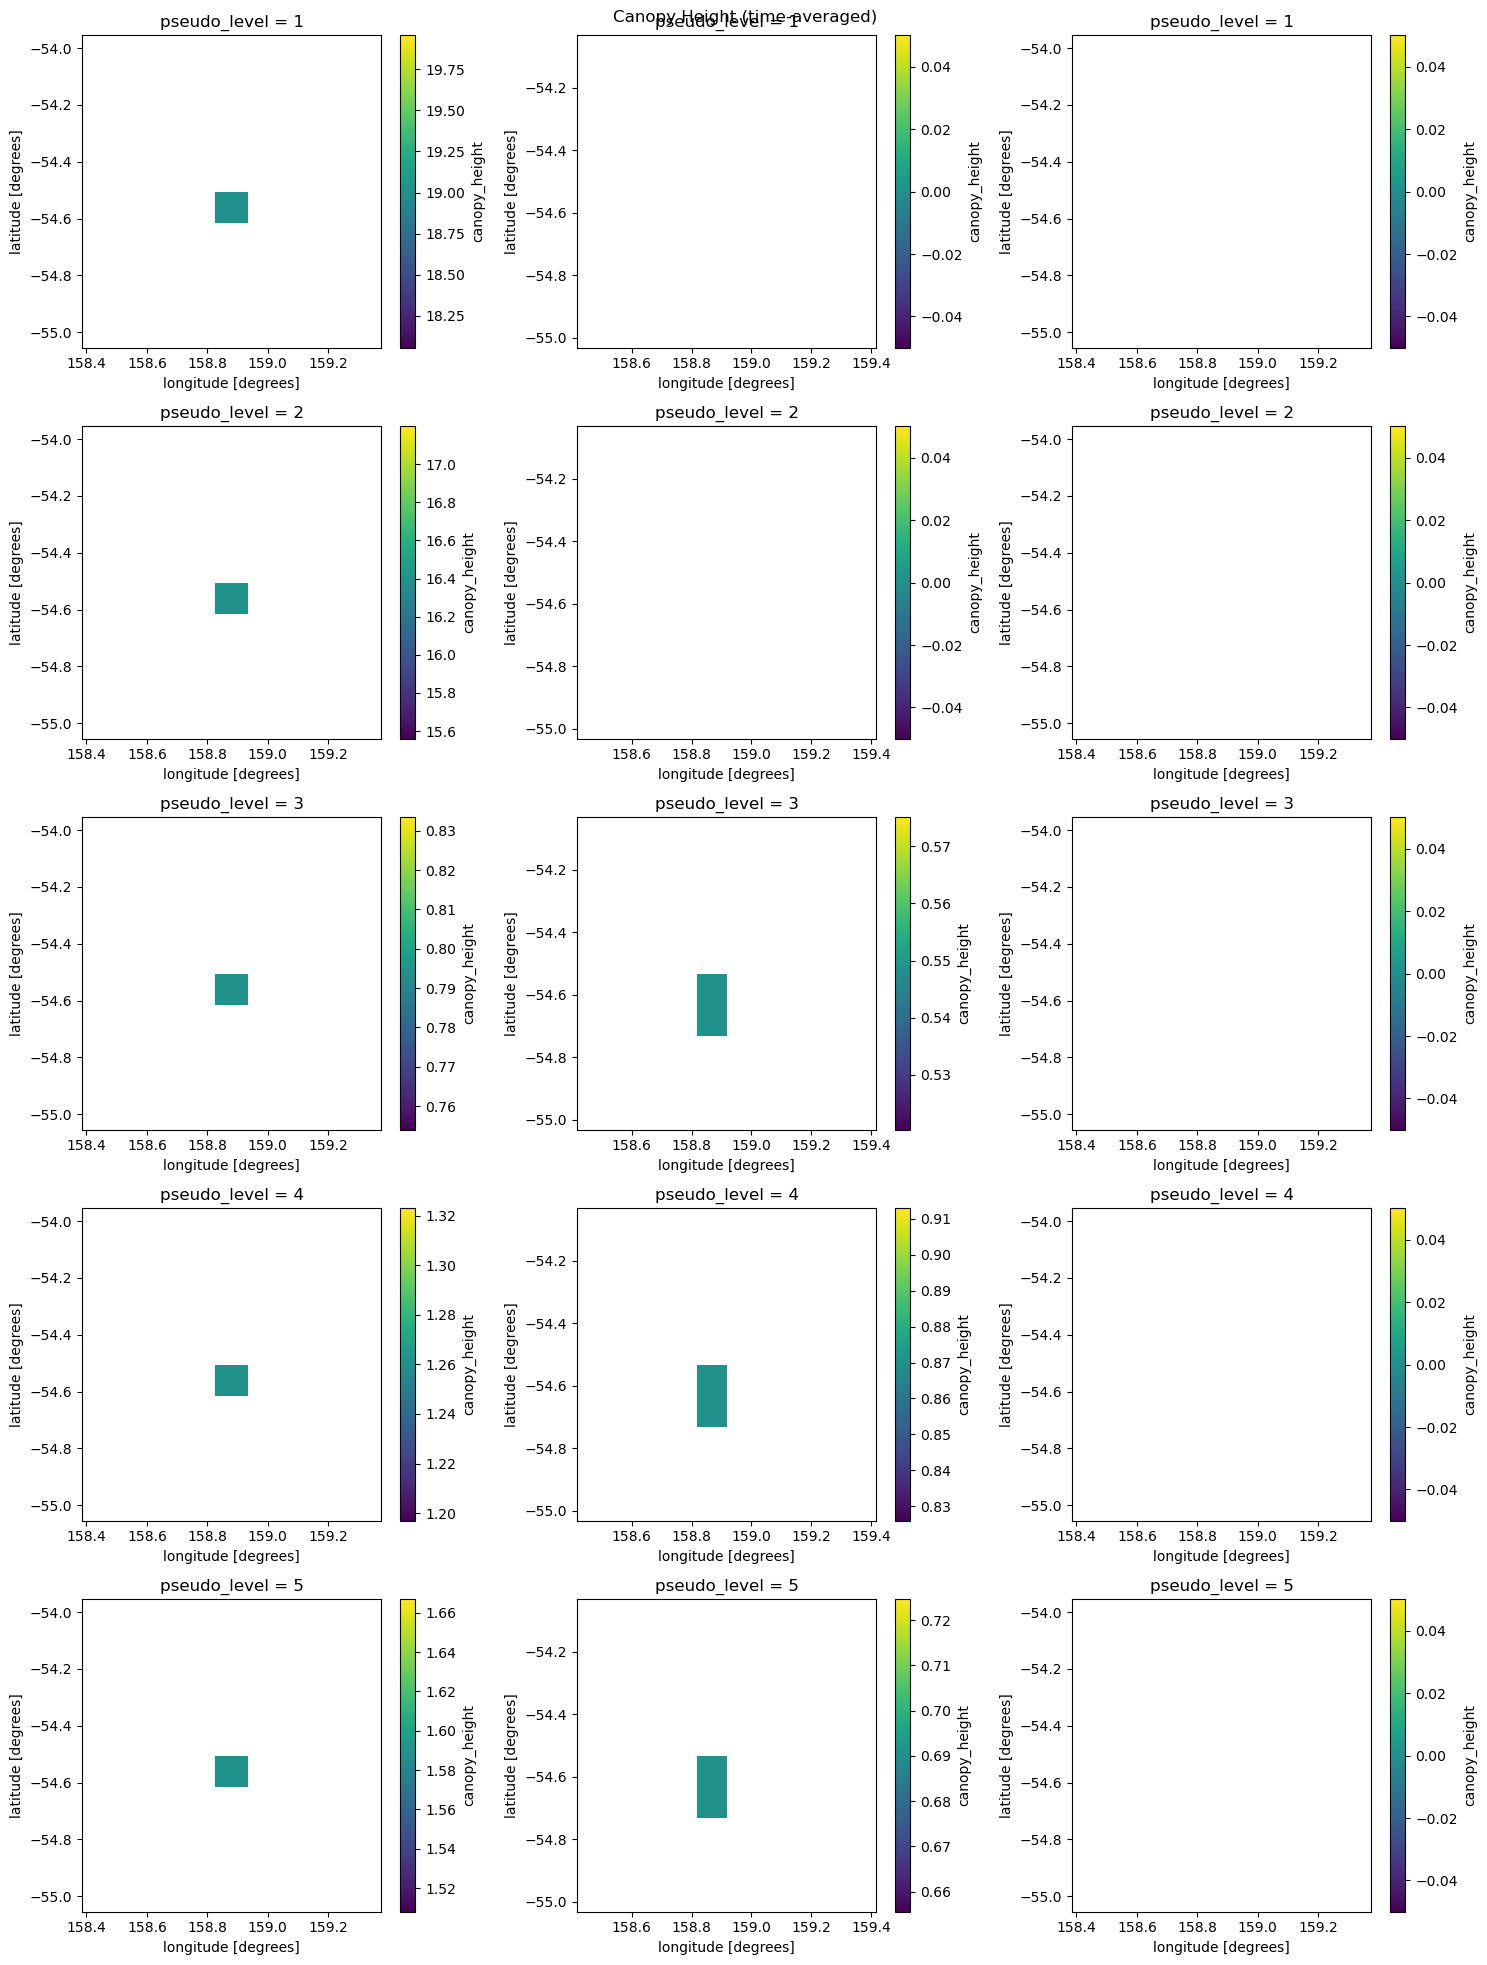

In [22]:
# Ok so func_type_modis had data for all five levels. 
# Let's repeat the earlier comparison
orig_veg_func_cube = ants.load( ORIG_PATH / 'vegetation/func_type_modis/qrparm.veg.func')[0]
orig_veg_func = xr.DataArray.from_iris(orig_veg_func_cube)

# Plot all canopy heights around Macquarie Island and average over time.
fig,ax=plt.subplots(5,3,figsize=(15,20))
levels = orig_veg_func.dim_0.values

for level in levels:

    orig = orig_veg_func.sel(latitude=slice(-55,-54),
                             longitude=slice(158.4,159.4),
                             dim_0=level).\
                             mean(dim='month_number')
    orig.plot(ax=ax[level,0])

    rns = rns_veg_func.sel(latitude=slice(-55,-54),
                           longitude=slice(158.4,159.4),
                           dim_0=level).\
                           mean(dim='time')
    rns.plot(ax=ax[level,1])

    lats = orig.latitude.values
    lons = orig.longitude.values
    
    delta = rns.interp(latitude=lats,longitude=lons)-orig
    delta.plot(ax=ax[level,2])

fig.suptitle('Canopy Height (time-averaged)')
plt.tight_layout()

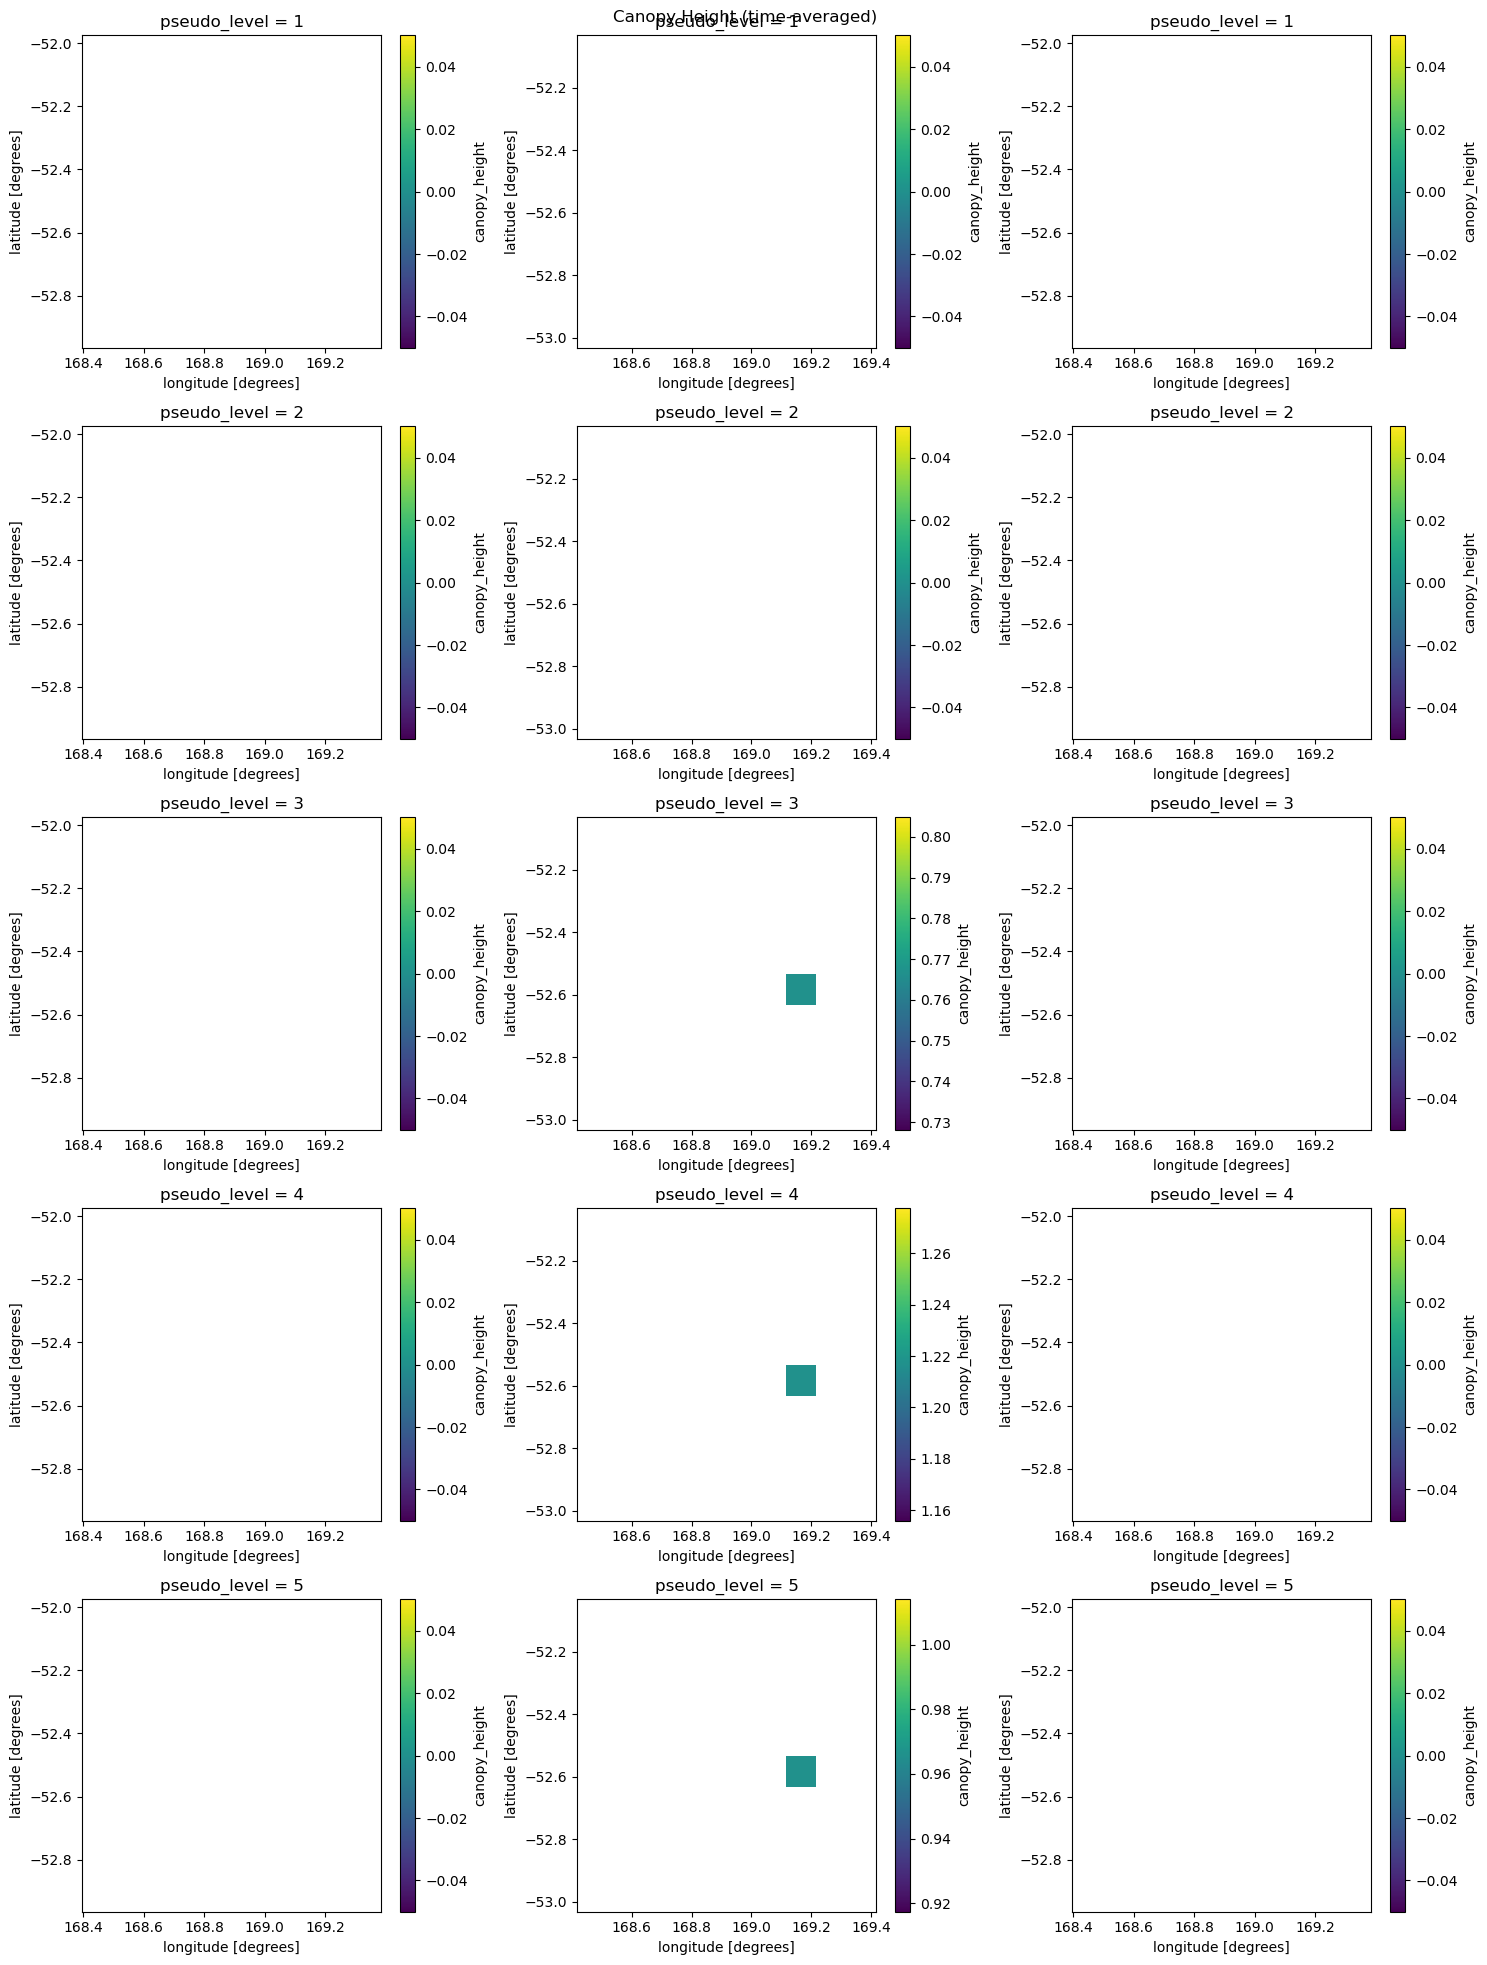

In [23]:
# The MODIS data seems to ignore Campbell Island?
# Plot all canopy heights around Macquarie Island and average over time.
fig,ax=plt.subplots(5,3,figsize=(15,20))
levels = orig_veg_func.dim_0.values

for level in levels:

    orig = orig_veg_func.sel(latitude=slice(-53,-52),
                             longitude=slice(168.4,169.4),
                             dim_0=level).\
                             mean(dim='month_number')
    orig.plot(ax=ax[level,0])

    rns = rns_veg_func.sel(latitude=slice(-53,-52),
                           longitude=slice(168.4,169.4),
                           dim_0=level).\
                           mean(dim='time')
    rns.plot(ax=ax[level,1])

    lats = orig.latitude.values
    lons = orig.longitude.values
    
    delta = rns.interp(latitude=lats,longitude=lons)-orig
    delta.plot(ax=ax[level,2])

fig.suptitle('Canopy Height (time-averaged)')
plt.tight_layout()


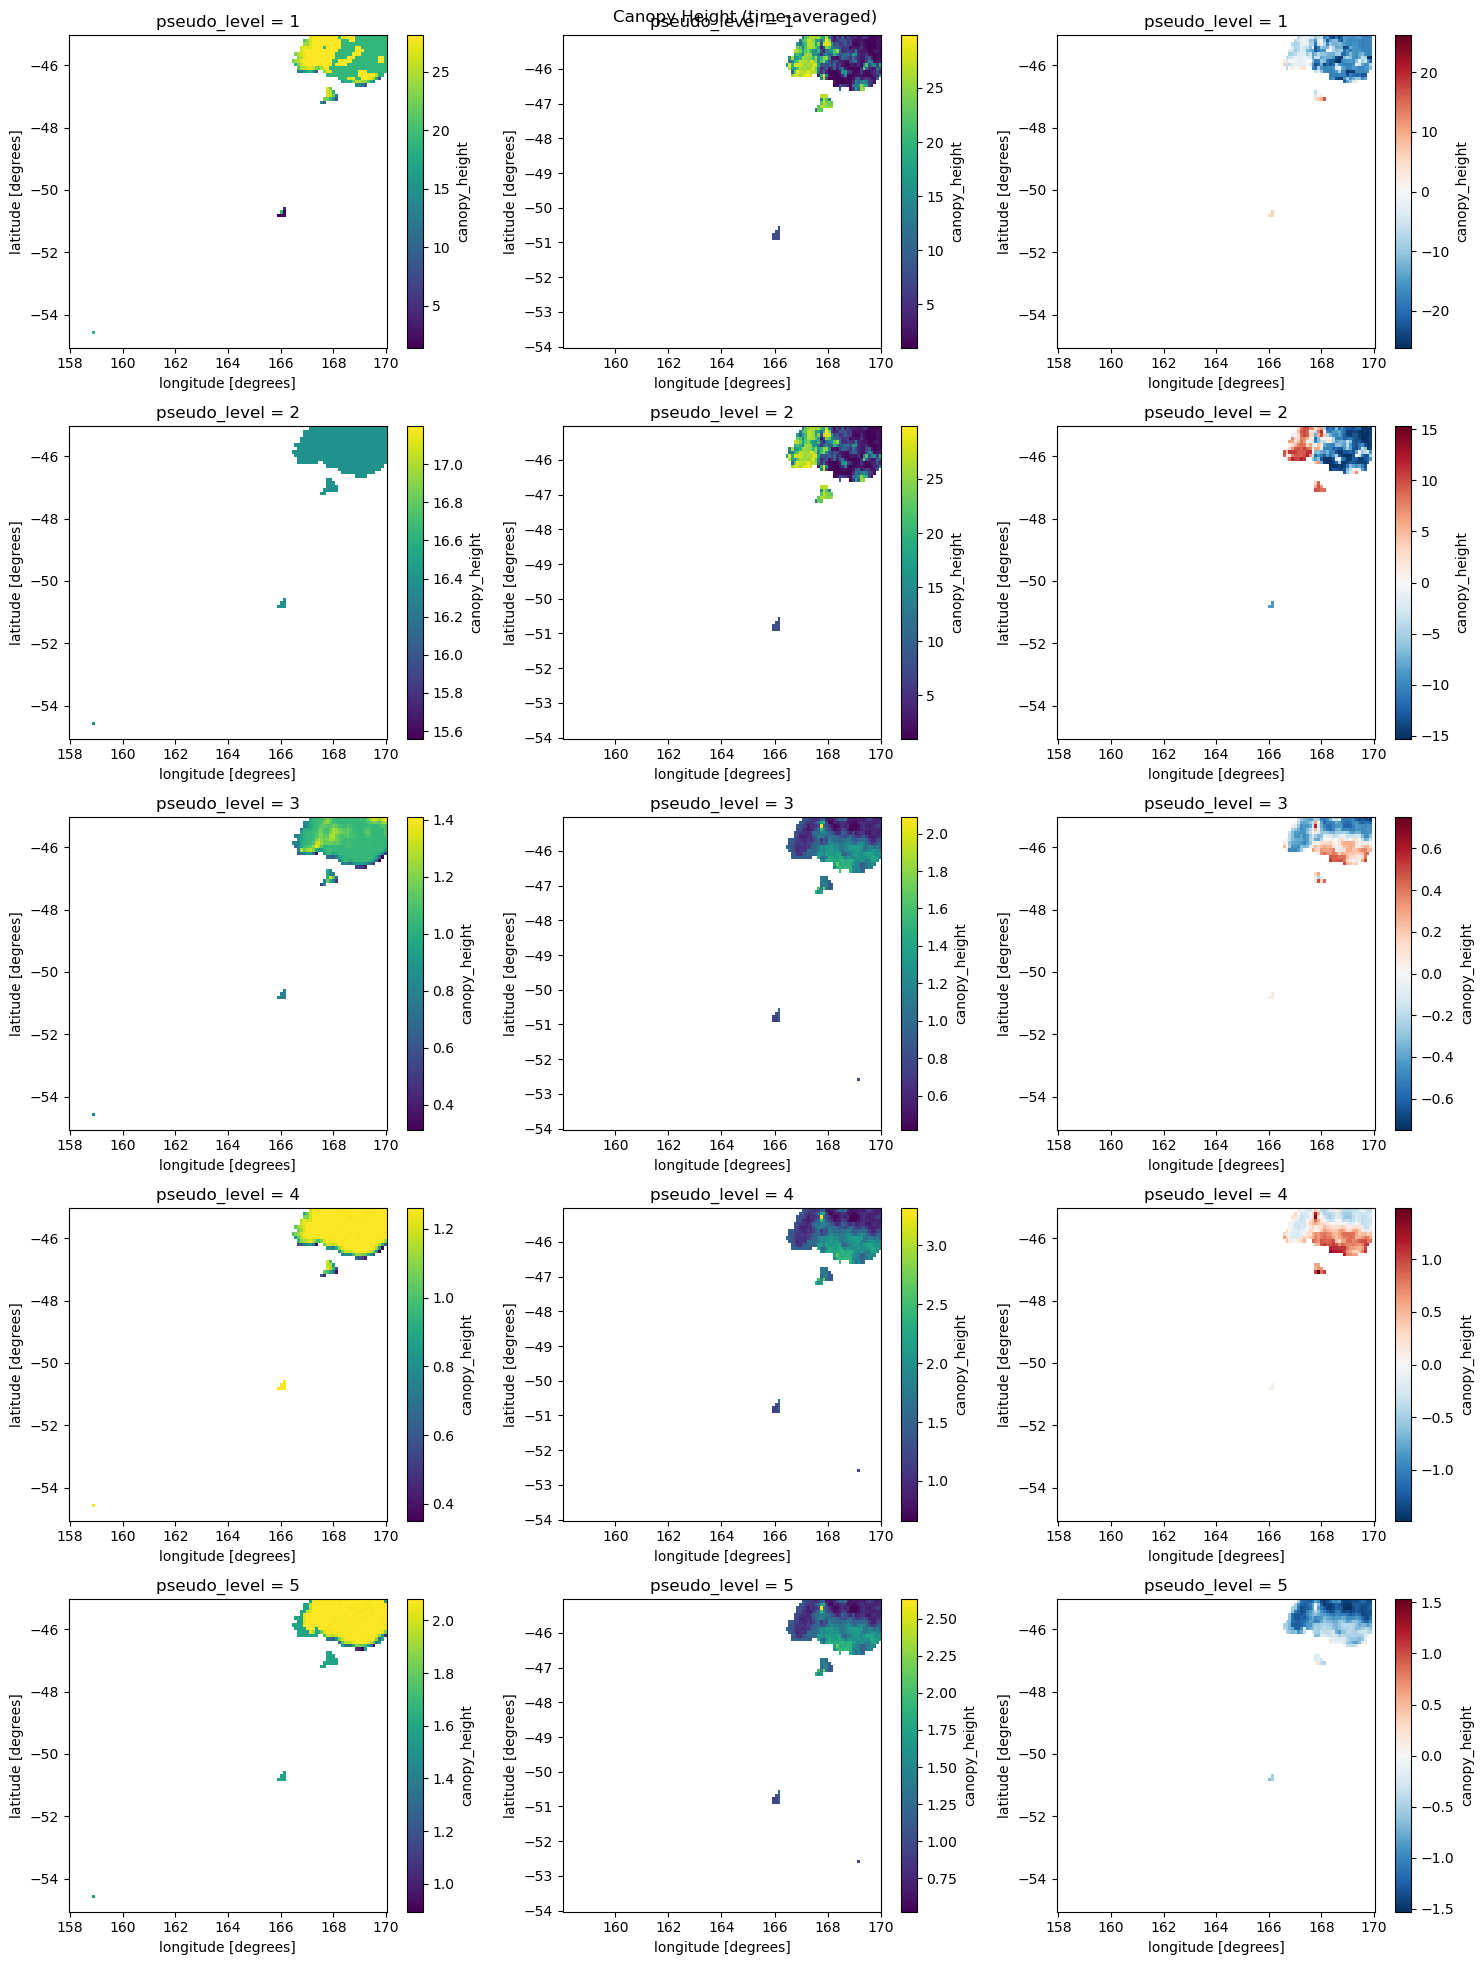

In [24]:
# Repeat MODIS for both islands and southern NZ
# Plot all canopy heights around Macquarie Island and average over time.
fig,ax=plt.subplots(5,3,figsize=(15,20))
levels = orig_veg_func.dim_0.values

for level in levels:

    orig = orig_veg_func.sel(latitude=slice(-55,-45),
                             longitude=slice(158,170),
                             dim_0=level).\
                             mean(dim='month_number')
    orig.plot(ax=ax[level,0])

    rns = rns_veg_func.sel(latitude=slice(-54,-45),
                           longitude=slice(158,170),
                           dim_0=level).\
                           mean(dim='time')
    rns.plot(ax=ax[level,1])

    lats = orig.latitude.values
    lons = orig.longitude.values
    
    delta = rns.interp(latitude=lats,longitude=lons)-orig
    delta.plot(ax=ax[level,2])

fig.suptitle('Canopy Height (time-averaged)')
plt.tight_layout()
